In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/u/student/2020/cs20btech11046/resnet/input"))

# Any results you write to the current directory are saved as output.

['archive.zip', 'skin-cancer-mnist-ham10000']


In [27]:
import pandas as pd 

df = pd.read_csv('/u/student/2020/cs20btech11046/resnet/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [28]:
from os.path import isfile
from PIL import Image as pil_image
df['num_images'] = df.groupby('lesion_id')["image_id"].transform("count")

classes = df['dx'].unique()
labeldict = {}
for num, name in enumerate(classes):
    labeldict[name] = num
df['dx_id'] = df['dx'].map(lambda x: labeldict[x])


def expand_path(p):
    if isfile('/u/student/2020/cs20btech11046/resnet/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'): return '/u/student/2020/cs20btech11046/resnet/input/skin-cancer-mnist-ham10000/ham10000_images_part_1/' + p + '.jpg'
    if isfile('/u/student/2020/cs20btech11046/resnet/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'): return '/u/student/2020/cs20btech11046/resnet/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/' + p + '.jpg'
    return p 
df['image_path'] = df['image_id']
df['image_path'] = df['image_path'].apply(expand_path)


df['images'] = df['image_path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,112))))
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,num_images,dx_id,image_path,images
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,0,/u/student/2020/cs20btech11046/resnet/input/sk...,"[[[188, 151, 193], [193, 156, 198], [192, 155,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,0,/u/student/2020/cs20btech11046/resnet/input/sk...,"[[[24, 13, 22], [24, 13, 22], [24, 14, 25], [2..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,0,/u/student/2020/cs20btech11046/resnet/input/sk...,"[[[186, 126, 135], [189, 131, 142], [192, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,0,/u/student/2020/cs20btech11046/resnet/input/sk...,"[[[23, 11, 16], [24, 11, 19], [26, 13, 22], [3..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,0,/u/student/2020/cs20btech11046/resnet/input/sk...,"[[[129, 87, 109], [139, 94, 117], [148, 102, 1..."


In [29]:
from sklearn.model_selection import train_test_split

df_single = df[df['num_images'] == 1]
trainset1, testset = train_test_split(df_single, test_size=0.2,random_state = 80)
trainset2, validationset = train_test_split(trainset1, test_size=0.2,random_state = 600)
trainset3 = df[df['num_images'] != 1]
frames = [trainset2, trainset3]
trainset = pd.concat(frames)
def prepareimages(images):
    # images is a list of images
    images = np.asarray(images).astype(np.float64)
    images = images[:, :, :, ::-1]
    m0 = np.mean(images[:, :, :, 0])
    m1 = np.mean(images[:, :, :, 1])
    m2 = np.mean(images[:, :, :, 2])
    images[:, :, :, 0] -= m0
    images[:, :, :, 1] -= m1
    images[:, :, :, 2] -= m2
    return images
trainimages = prepareimages(list(trainset['images']))
testimages = prepareimages(list(testset['images']))
validationimages = prepareimages(list(validationset['images']))
trainlabels = np.asarray(trainset['dx_id'])
testlabels = np.asarray(testset['dx_id'])
validationlabels = np.asarray(validationset['dx_id'])

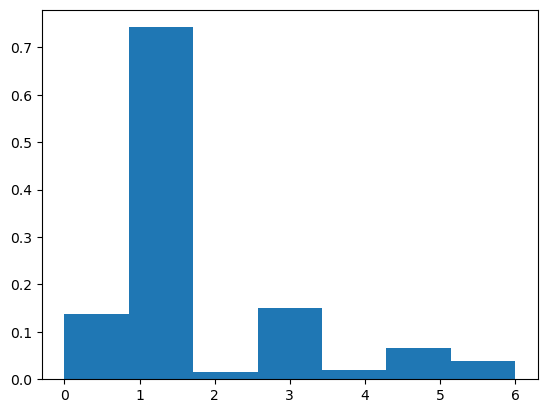

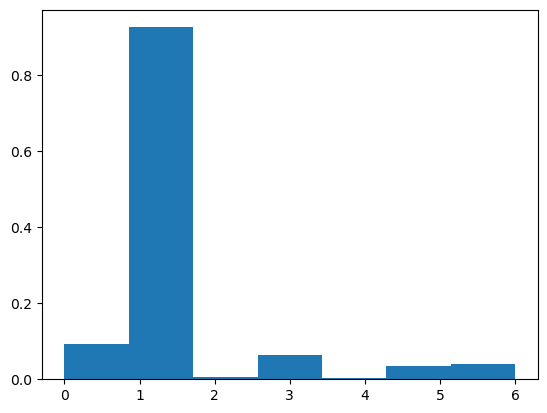

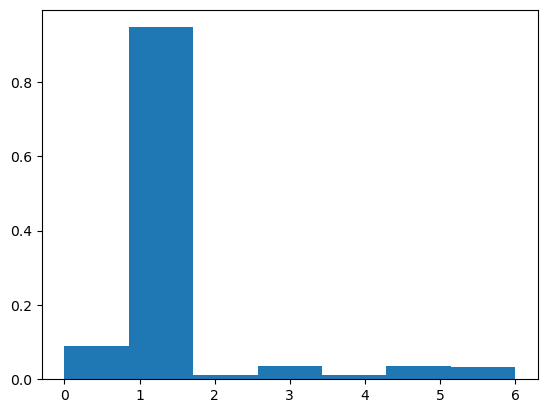

In [30]:
import matplotlib.pyplot as plt

plt.hist(trainlabels,bins = 7,density = True)
plt.show()

plt.hist(validationlabels,bins = 7,density= True)
plt.show()

plt.hist(testlabels,bins = 7,density= True)
plt.show()

In [31]:
from keras.preprocessing.image import ImageDataGenerator

trainimages = trainimages.reshape(trainimages.shape[0], *(112, 150, 3))

data_gen = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1)  # randomly shift images vertically
#x = imageLoader(trainset,batch_size)
data_gen.fit(trainimages)


In [32]:
#from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import regularizers

model = Sequential()
num_labels = 7

base_model = ResNet50(include_top=False, input_shape=(112, 150, 3),pooling = 'avg', weights = None)
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-22:]:
    layer.trainable = True

#model.add(ResNet50(include_top = False, pooling = 'max', weights = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 23850887 (90.98 MB)
Trainable params: 9194503 (35.07 MB)
Non-trainable params: 14656384 (55.91 MB)
_________________________________________________________________


In [33]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam (learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [46]:
trainimages.shape[0] // batch_size

401

In [66]:
# Fit the model
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self, **kargs):
        super(CustomModelCheckPoint, self).__init__(**kargs)
        self.epoch_accuracy = {}  # loss at given epoch
        self.epoch_loss = {}  # accuracy at given epoch

    def on_epoch_begin(self, epoch, logs=None):
        # Things done at the beginning of epoch.
        return

    def on_epoch_end(self, epoch, logs=None):
        # Things done at the end of the epoch
        self.epoch_accuracy[epoch] = logs.get("acc")
        self.epoch_loss[epoch] = logs.get("loss")
        self.model.save_weights("/u/student/2020/cs20btech11046/resnet/output/resnet50/name-of-model-%d.h5" % epoch)

cb_early_stopper = EarlyStopping(monitor='val_loss', patience=4)
# cb_checkpointer = ModelCheckpoint(filepath='/u/student/2020/cs20btech11046/resnet/working/best.hdf5', monitor='val_loss', save_best_only=True, mode='auto')

epochs = 30
batch_size = 20
trainhistory = model.fit(data_gen.flow(trainimages, trainlabels, batch_size=batch_size),epochs=epochs, validation_data=(validationimages, validationlabels),verbose=1, steps_per_epoch=trainimages.shape[0] // batch_size,callbacks=[cb_early_stopper])


Epoch 1/30


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [55]:
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self, **kwargs):
        super(CustomModelCheckPoint, self).__init__(**kwargs)
        self.epoch_accuracy = {}  # accuracy at a given epoch
        self.epoch_loss = {}  # loss at a given epoch

    def on_epoch_begin(self, epoch, logs=None):
        # Things done at the beginning of an epoch.
        return

    def on_epoch_end(self, epoch, logs=None):
        # Things done at the end of an epoch.
        self.epoch_accuracy[epoch] = logs.get("acc")
        self.epoch_loss[epoch] = logs.get("loss")
        self.model.save_weights("/u/student/2020/cs20btech11046/resnet/output/resnet50/name-of-model-%d.h5" % epoch)

# Define your callbacks
cb_early_stopper = EarlyStopping(monitor='val_loss', patience=4)
 #cb_checkpointer = ModelCheckpoint(filepath='/u/student/2020/cs20btech11046/resnet/working/best.hdf5',
                                   monitor='val_loss', save_best_only=True, mode='auto')

# Train your model
epochs = 30
batch_size = 20
trainhistory = model.fit(data_gen.flow(trainimages, trainlabels, batch_size=batch_size),
                         epochs=epochs, validation_data=(validationimages, validationlabels),
                         verbose=1, steps_per_epoch=trainimages.shape[0] // batch_size,
                         callbacks=[ cb_early_stopper])


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 29)

In [61]:
import tensorflow
tensorflow.config.run_functions_eagerly(True)

In [67]:
# Fit the model
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
class CustomModelCheckPoint(keras.callbacks.Callback):
    def __init__(self,**kargs):
        super(CustomModelCheckPoint,self).__init__(**kargs)
        self.epoch_accuracy = {} # loss at given epoch
        self.epoch_loss = {} # accuracy at given epoch
        def on_epoch_begin(self,epoch, logs={}):
            # Things done on beginning of epoch. 
            return

        def on_epoch_end(self, epoch, logs={}):
            # things done on end of the epoch
            self.epoch_accuracy[epoch] = logs.get("acc")
            self.epoch_loss[epoch] = logs.get("loss")
            self.model.save_weights("/u/student/2020/cs20btech11046/resnet/output/resnet50/name-of-model-%d.h5" %epoch)
            
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 4)
#cb_checkpointer = ModelCheckpoint(filepath = '/u/student/2020/cs20btech11046/resnet/working/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')
            
epochs = 30 
batch_size = 20
trainhistory = model.fit(data_gen.flow(trainimages,trainlabels, batch_size=batch_size),epochs = epochs, validation_data = (validationimages,validationlabels),verbose = 1, steps_per_epoch=trainimages.shape[0] // batch_size,callbacks=[ cb_early_stopper])

Epoch 1/30


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
import matplotlib.pyplot as plt
acc = trainhistory.history['acc']
val_acc = trainhistory.history['val_acc']
loss = trainhistory.history['loss']
val_loss = trainhistory.history['val_loss']


epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, '', label='Training loss')
plt.plot(epochs, val_loss, '', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, '', label='Training accuracy')
plt.plot(epochs, val_acc, '', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
model.load_weights("/u/student/2020/cs20btech11046/resnet/working/best.hdf5")
test_loss, test_acc = model.evaluate(testimages, testlabels, verbose=1)
print("test_accuracy = %f  ;  test_loss = %f" % (test_acc, test_loss))

In [ ]:
from sklearn.metrics import confusion_matrix
train_pred = model.predict(trainimages)
train_pred_classes = np.argmax(train_pred,axis = 1)
test_pred = model.predict(testimages)
# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred,axis = 1) 

confusionmatrix = confusion_matrix(testlabels, test_pred_classes)
confusionmatrix

In [ ]:
from sklearn.metrics import classification_report
labels = labeldict.keys()
# Generate a classification report
trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
testreport = classification_report(testlabels, test_pred_classes, target_names=list(labels))

print(trainreport)
print(testreport)